# Deep Reinforcement Learning

In [1]:
%pip install numpy torch matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math, random, statistics, collections
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt

random.seed(0); np.random.seed(0); torch.manual_seed(0)
torch.__version__

'2.8.0'

## What is reinforcement learning?

An agent interacts with an environment in discrete time steps. At time $t$ the agent is in state $S_t$, chooses action $A_t$, receives reward $R_{t+1}$ and transitions to $S_{t+1}$. The goal is to **maximize expected return**.

- **Return (undiscounted):** $G_t = R_{t+1} + R_{t+2} + \dots + R_T$
- **Discounted return:** $G_t = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}$ with $0\le \gamma \le 1$

A Markov Decision Process (MDP) satisfies the **Markov property**: the future depends only on the present state and action, not on the past.


## Value functions and the Bellman equation

- **State value:** $v_\pi(s) = \mathbb{E}_\pi\!\left[ G_t \mid S_t=s \right]$  
- **Action value:** $q_\pi(s,a) = \mathbb{E}_\pi\!\left[ G_t \mid S_t=s, A_t=a \right]$

**Bellman expectation equation (state value):**
$$
v_\pi(s) = \sum_a \pi(a\mid s) \sum_{s',r} p(s',r\mid s,a)\,\big[\, r + \gamma v_\pi(s') \,\big].
$$
This recursion underlies many RL algorithms.


## Multi-armed bandits and $\epsilon$-greedy

Bandits capture the **exploration vs. exploitation** tradeoff. We maintain an estimate $Q_t(a)$ of the expected reward per arm and select:
- With probability $1-\epsilon$: greedy action $\arg\max_a Q_t(a)$ (exploit)
- With probability $\epsilon$: a random action (explore)

Incremental mean update for the chosen arm $A_t$ with reward $R_t$:
$$
Q_{t+1}(A_t) \leftarrow Q_t(A_t) + \alpha\,[R_t - Q_t(A_t)],
$$
with $\alpha=\tfrac{1}{N_t(A_t)}$ (sample-average) or a constant step size.


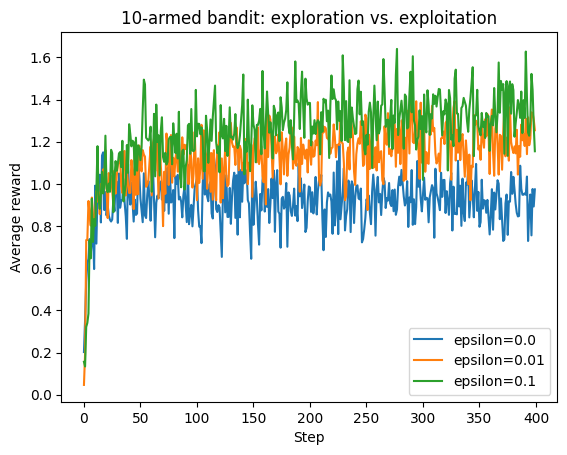

(1.1550874841577843, 1.254686941706549, 0.9742780129861014)

In [3]:
# 10-armed bandit testbed: compare epsilons
def run_bandit(eps=0.1, steps=500, runs=100):
    avg_rewards = np.zeros(steps)
    for _ in range(runs):
        # true action values (stationary)
        q_star = np.random.normal(0, 1, size=10)
        Q = np.zeros(10, dtype=float)
        N = np.zeros(10, dtype=int)
        rewards = []
        for t in range(steps):
            if random.random() < eps:
                a = random.randrange(10)
            else:
                a = int(np.argmax(Q))
            # draw reward
            r = np.random.normal(q_star[a], 1.0)
            N[a] += 1
            # sample-average step size
            Q[a] += (r - Q[a]) / N[a]
            rewards.append(r)
        avg_rewards += np.array(rewards)
    return avg_rewards / runs

steps = 400
r_eps0  = run_bandit(eps=0.0, steps=steps, runs=100)  # purely greedy
r_eps01 = run_bandit(eps=0.1, steps=steps, runs=100)
r_eps001= run_bandit(eps=0.01, steps=steps, runs=100)

plt.figure()
plt.plot(r_eps0,  label="epsilon=0.0")
plt.plot(r_eps001,label="epsilon=0.01")
plt.plot(r_eps01, label="epsilon=0.1")
plt.xlabel("Step"); plt.ylabel("Average reward"); plt.legend(); plt.title("10-armed bandit: exploration vs. exploitation")
plt.show()

float(r_eps01[-1]), float(r_eps001[-1]), float(r_eps0[-1])

## Monte Carlo (MC) prediction

MC estimates $v_\pi$ by averaging **complete returns** from episodes:
$$
V(S_t) \leftarrow V(S_t) + \alpha \big[G_t - V(S_t)\big].
$$

Pros: unbiased, no model required. Cons: high variance and must wait until the episode ends.


## A tiny episodic gridworld

We use a $4\times 4$ grid with terminal states at the corners. Actions: up/down/left/right with equal probability under a **random policy**. Reward $-1$ per step (shorter paths are better). We compare **MC** and **TD(0)** estimates of $v_\pi$.


In [4]:
# 4x4 Gridworld under a fixed random policy
ACTIONS = [(1,0),(-1,0),(0,1),(0,-1)]  # down, up, right, left

def step(s, a):
    r, c = s
    dr, dc = a
    nr, nc = max(0, min(3, r+dr)), max(0, min(3, c+dc))
    ns = (nr, nc)
    terminal = ns in [(0,0),(3,3)]
    reward = 0.0 if terminal and ns==(3,3) else -1.0
    return ns, reward, terminal

def random_act():
    return ACTIONS[random.randrange(4)]

def generate_episode():
    s = (0,1)  # start near a corner to keep episodes short-ish
    ep = []
    done = False
    while not done and len(ep) < 100:
        a = random_act()
        ns, r, done = step(s,a)
        ep.append((s,a,r))
        s = ns
    return ep

# Monte Carlo prediction (first-visit) vs TD(0)
def mc_predict(gamma=1.0, episodes=500, alpha=0.1):
    V = collections.defaultdict(float)
    visited = collections.defaultdict(bool)
    for _ in range(episodes):
        ep = generate_episode()
        G = 0.0
        seen = set()
        for t in reversed(range(len(ep))):
            s, a, r = ep[t]
            G = r + gamma*G
            if s not in seen:
                V[s] += alpha*(G - V[s])
                seen.add(s)
    return V

def td0_predict(gamma=1.0, episodes=500, alpha=0.1):
    V = collections.defaultdict(float)
    for _ in range(episodes):
        s = (0,1)
        done=False; t=0
        while not done and t<100:
            a = random_act()
            ns, r, done = step(s,a)
            target = r + (0 if done else gamma*V[ns])
            V[s] += alpha*(target - V[s])
            s = ns; t+=1
    return V

V_mc = mc_predict(episodes=800, alpha=0.05)
V_td = td0_predict(episodes=800, alpha=0.1)

def grid_from_V(V):
    G = np.zeros((4,4))
    for r in range(4):
        for c in range(4):
            G[r,c] = V[(r,c)]
    return G

G_mc = grid_from_V(V_mc)
G_td = grid_from_V(V_td)
G_mc, G_td

(array([[  0.        ,  -8.69915909, -12.1984038 , -14.94234448],
        [-10.75408122,  -7.67182311,  -8.66904984, -11.02720418],
        [-13.19995278,  -8.72285248,  -8.94226276,  -7.37106006],
        [-13.15032552, -10.93451921,  -5.44402703,   0.        ]]),
 array([[  0.        , -10.77577266, -17.95547534, -20.45219377],
        [-11.29000129, -14.84277759, -17.48794102, -19.06000607],
        [-17.97416551, -17.51049   , -15.12015375, -13.6380632 ],
        [-19.84949875, -16.82718717,  -8.71126085,   0.        ]]))

## Temporal-Difference (TD) learning

TD updates **bootstrapped** targets using current estimates:
$$
V(S_t) \leftarrow V(S_t) + \alpha \big[ R_{t+1} + \gamma V(S_{t+1}) - V(S_t) \big].
$$

Pros: lower variance and online updates; Cons: introduces bias (because we bootstrap from estimates).


## Control via action values: SARSA and Q-learning

We now estimate **action values** and improve the policy using $\epsilon$-greedy.

- **SARSA (on-policy):**
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \big[ R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t) \big].
$$

- **Q-learning (off-policy):**
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \big[ R_{t+1} + \gamma \max_a Q(S_{t+1},a) - Q(S_t,A_t) \big].
$$

We compare both on a small **cliff-walking**-style grid: stepping into the cliff gives a large negative reward and sends you back to start.


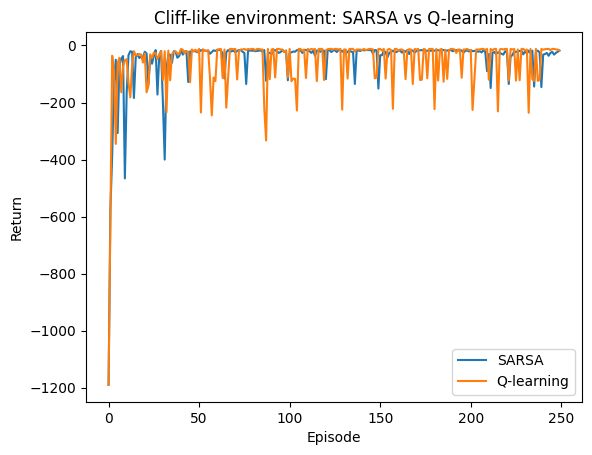

(-36.75, -46.45)

In [5]:
# Minimal cliff-walking-like environment
H,W = 4, 12
START = (3,0); GOAL = (3,11)
CLIFF = {(3,c) for c in range(1,11)}

def step_cliff(s, a):
    r,c = s; dr,dc = a
    nr, nc = max(0,min(H-1,r+dr)), max(0,min(W-1,c+dc))
    ns = (nr,nc)
    if ns in CLIFF:
        return START, -100.0, False
    if ns == GOAL:
        return ns, 0.0, True
    return ns, -1.0, False

ACTIONS_C = ACTIONS  # reuse
def eps_greedy(Q, s, eps=0.1):
    if random.random() < eps:
        return ACTIONS_C[random.randrange(len(ACTIONS_C))]
    qs = [Q[(s,a)] for a in ACTIONS_C]
    return ACTIONS_C[int(np.argmax(qs))]

def run_sarsa(episodes=200, alpha=0.5, gamma=1.0, eps=0.1):
    Q = collections.defaultdict(float)
    returns = []
    for ep in range(episodes):
        s = START
        a = eps_greedy(Q, s, eps)
        G = 0.0; done=False; t=0
        while not done and t<200:
            ns, r, done = step_cliff(s, a)
            G += r
            na = eps_greedy(Q, ns, eps) if not done else None
            target = r + (0 if done else gamma*Q[(ns,na)])
            Q[(s,a)] += alpha*(target - Q[(s,a)])
            s,a = ns, (na if na is not None else a)
            t+=1
        returns.append(G)
    return Q, returns

def run_qlearning(episodes=200, alpha=0.5, gamma=1.0, eps=0.1):
    Q = collections.defaultdict(float)
    returns = []
    for ep in range(episodes):
        s = START
        G = 0.0; done=False; t=0
        while not done and t<200:
            a = eps_greedy(Q, s, eps)
            ns, r, done = step_cliff(s, a)
            G += r
            max_next = 0.0 if done else max(Q[(ns,aa)] for aa in ACTIONS_C)
            target = r + gamma*max_next
            Q[(s,a)] += alpha*(target - Q[(s,a)])
            s = ns; t+=1
        returns.append(G)
    return Q, returns

Qs, ret_s = run_sarsa(episodes=250, eps=0.1)
Qq, ret_q = run_qlearning(episodes=250, eps=0.1)

plt.figure()
plt.plot(ret_s, label="SARSA")
plt.plot(ret_q, label="Q-learning")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.legend(); plt.title("Cliff-like environment: SARSA vs Q-learning")
plt.show()

float(np.mean(ret_s[-20:])), float(np.mean(ret_q[-20:]))

## From tabular methods to Deep Q-Networks (DQN)

Key ideas used to scale value-based control to high-dimensional inputs (e.g., Atari from pixels):

- **Function approximation:** use a neural network to approximate $Q_\theta(s,a)$.
- **Experience replay:** store recent transitions and sample mini-batches to decorrelate updates.
- **Target network:** use a lagged copy of parameters for stable targets.

(These additions stabilize training and make bootstrapping with deep nets feasible.)


## A super-tiny DQN skeleton (toy state only)

Below is a minimal DQN loop on a tiny **vector state** environment to show the replay + target network mechanics. It is not meant for performance; it just demonstrates shapes and updates quickly.


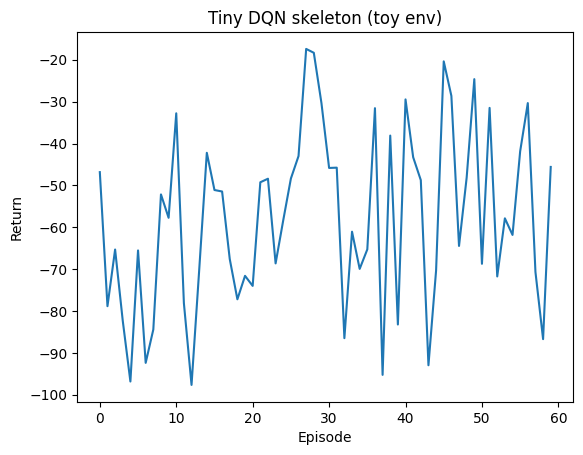

-56.68616255521774

In [6]:
# Toy environment with vector states in R^4 and 2 actions; terminal after 30 steps or if norm<0.1
class TinyEnv:
    def __init__(self):
        self.reset()
    def reset(self):
        self.t=0
        self.s = np.random.randn(4).astype(np.float32)
        return self.s.copy()
    def step(self, a):
        self.t += 1
        # drift towards origin; action perturbs dynamics
        self.s = (self.s + (0.05 if a==0 else -0.05)).astype(np.float32)
        r = -float(np.linalg.norm(self.s))  # closer to 0 is better
        done = self.t>=30 or np.linalg.norm(self.s)<0.1
        return self.s.copy(), r, done, {}

# Q-network
class QNet(nn.Module):
    def __init__(self, din=4, nact=2, hid=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(din, hid), nn.ReLU(),
            nn.Linear(hid, hid), nn.ReLU(),
            nn.Linear(hid, nact),
        )
    def forward(self, x):
        return self.net(x)

# Replay buffer
class Replay:
    def __init__(self, cap=10000):
        self.cap = cap; self.buf = collections.deque(maxlen=cap)
    def push(self, *tr):
        self.buf.append(tuple(tr))
    def sample(self, batch):
        idx = np.random.choice(len(self.buf), batch, replace=False)
        batch = [self.buf[i] for i in idx]
        s,a,r,ns,d = zip(*batch)
        return (torch.tensor(np.array(s), dtype=torch.float32),
                torch.tensor(a, dtype=torch.long),
                torch.tensor(r, dtype=torch.float32),
                torch.tensor(np.array(ns), dtype=torch.float32),
                torch.tensor(d, dtype=torch.float32))
    def __len__(self): return len(self.buf)

def select_action(qnet, s, eps=0.1):
    if random.random()<eps:
        return random.randrange(2)
    with torch.no_grad():
        q = qnet(torch.tensor(s[None,:], dtype=torch.float32))
        return int(q.argmax(dim=1).item())

env = TinyEnv()
q     = QNet(); q_tgt = QNet(); q_tgt.load_state_dict(q.state_dict())
opt   = optim.Adam(q.parameters(), lr=1e-3)
buf   = Replay(2000)

gamma=0.98; eps=0.2; batch=32; sync_every=50
returns = []
for ep in range(60):
    s = env.reset(); done=False; G=0.0
    while not done:
        a = select_action(q, s, eps)
        ns, r, done, _ = env.step(a)
        buf.push(s,a,r,ns, done)
        s = ns; G += r
        if len(buf)>=200:
            S,A,R,NS,D = buf.sample(batch)
            with torch.no_grad():
                max_next = q_tgt(NS).max(dim=1).values
                target = R + gamma*(1.0-D)*max_next
            pred = q(S).gather(1, A.view(-1,1)).squeeze(1)
            loss = F.mse_loss(pred, target)
            opt.zero_grad(); loss.backward(); opt.step()
        if (ep*30) % sync_every == 0:
            q_tgt.load_state_dict(q.state_dict())
    returns.append(G)

plt.figure()
plt.plot(returns)
plt.xlabel("Episode"); plt.ylabel("Return")
plt.title("Tiny DQN skeleton (toy env)")
plt.show()

float(np.mean(returns[-10:]))

## Summary

- **Bandits** motivate exploration vs. exploitation and incremental action-value estimation.
- **MC vs TD:** unbiased high-variance complete returns vs. biased low-variance bootstrapping.
- **SARSA vs Q-learning:** on-policy vs. off-policy control; behavior differences on risky tasks.
- **DQN mechanics:** replay + target network stabilize deep value learning.

Next steps:
- Swap toy domains for Gymnasium tasks (CartPole) and connect the DQN skeleton.
- Try **prioritized replay** and **double Q-learning** for more stability.
- Move beyond value-based methods to **policy gradients** and **actor–critic**.


## Function approximation for values and action-values

Tabular methods break down when $|S|$ or $|A|$ is large/continuous. We therefore approximate:
$$
\hat{v}(s;w)\approx v_\pi(s), \qquad \hat{q}(s,a;w) \approx q_\pi(s,a),
$$
and learn $w$ by minimizing a suitable objective (e.g., mean weighted error over states). In practice
we use **neural networks** and **stochastic gradient descent** with targets from MC/TD/Q-learning.


## Deep Q-Learning recap: moving target & target networks

If we use the same network parameters $w$ to build targets
$y=R+\gamma\max_{a'} \hat{Q}(S',a';w)$, the **target moves** as $w$ updates.
Stabilization tricks:
- **Target network** $w^{-}$ to build targets, updated slowly.
- **Experience replay** buffer $D$ to decorrelate samples.


## A tiny vector-state environment + uniform replay

We keep a very small **vector** state to make training instant. The agent tries to drive the state to $0$.
Reward is $-||s||$; episode ends after a few steps.


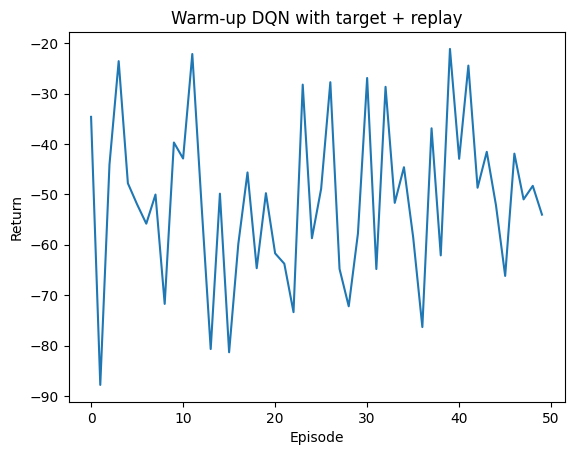

(-47.11579678654671, 1250)

In [8]:
# Tiny environment with vector states in R^4 and 2 actions; short episodes
class TinyEnv:
    def __init__(self, T=30):
        self.Tmax = T
        self.reset()
    def reset(self):
        self.t=0
        self.s = np.random.randn(4).astype(np.float32)
        return self.s.copy()
    def step(self, a):
        self.t += 1
        # drift towards/away from origin; action perturbs trend
        self.s = (self.s + (0.05 if a==0 else -0.05)).astype(np.float32)
        r = -float(np.linalg.norm(self.s))  # closer to 0 is better
        done = self.t>=self.Tmax or np.linalg.norm(self.s)<0.1
        return self.s.copy(), r, done, {}

# Uniform replay buffer
class Replay:
    def __init__(self, cap=10000):
        self.cap = cap; self.buf = collections.deque(maxlen=cap)
    def push(self, *tr):
        self.buf.append(tuple(tr))
    def sample(self, batch):
        idx = np.random.choice(len(self.buf), batch, replace=False)
        s,a,r,ns,d = zip(*[self.buf[i] for i in idx])
        return (torch.tensor(np.array(s), dtype=torch.float32),
                torch.tensor(a, dtype=torch.long),
                torch.tensor(r, dtype=torch.float32),
                torch.tensor(np.array(ns), dtype=torch.float32),
                torch.tensor(d, dtype=torch.float32))
    def __len__(self): return len(self.buf)

# Q-network
class QNet(nn.Module):
    def __init__(self, din=4, nact=2, hid=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(din, hid), nn.ReLU(),
            nn.Linear(hid, hid), nn.ReLU(),
            nn.Linear(hid, nact),
        )
    def forward(self, x):
        return self.net(x)

def select_action(qnet, s, eps=0.1):
    if random.random()<eps: return random.randrange(2)
    with torch.no_grad():
        q = qnet(torch.tensor(s[None,:], dtype=torch.float32))
        return int(q.argmax(dim=1).item())

# One short DQN training to fill replay and stabilize
env = TinyEnv(T=25)
q     = QNet(); q_tgt = QNet(); q_tgt.load_state_dict(q.state_dict())
opt   = optim.Adam(q.parameters(), lr=1e-3)
buf   = Replay(2000)

gamma=0.98; eps=0.2; batch=32; sync_every=50
returns = []
for ep in range(50):
    s = env.reset(); done=False; G=0.0
    while not done:
        a = select_action(q, s, eps)
        ns, r, done, _ = env.step(a)
        buf.push(s,a,r,ns, done)
        s = ns; G += r
        if len(buf)>=256:
            S,A,R,NS,D = buf.sample(batch)
            with torch.no_grad():
                max_next = q_tgt(NS).max(dim=1).values
                target = R + gamma*(1.0-D)*max_next
            pred = q(S).gather(1, A.view(-1,1)).squeeze(1)
            loss = F.mse_loss(pred, target)
            opt.zero_grad(); loss.backward(); opt.step()
        if (ep*25) % sync_every == 0:
            q_tgt.load_state_dict(q.state_dict())
    returns.append(G)

plt.figure(); plt.plot(returns); plt.xlabel("Episode"); plt.ylabel("Return"); plt.title("Warm-up DQN with target + replay"); plt.show()
float(np.mean(returns[-10:])), len(buf)

## Double DQN

Reduces **overestimation bias** in Q-learning by using the **online** network to select the action and the
**target** network to evaluate it:
$$
y = R + \gamma\,\hat{Q}(S', \arg\max_a \hat{Q}(S',a;w)\,;\,w^{-}).
$$
We compare a few training steps of DQN vs. **Double DQN** on the tiny environment.


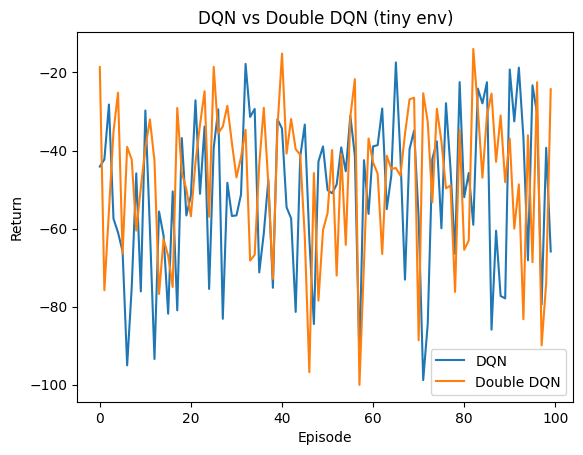

(-41.38556925356388, -54.41593155860901)

In [9]:
def train_double(env, steps=1500, double=True):
    q, q_tgt = QNet(), QNet(); q_tgt.load_state_dict(q.state_dict())
    opt = optim.Adam(q.parameters(), lr=1e-3)
    buf = Replay(4000)
    gamma=0.98; eps=0.2; batch=64; sync_every=100
    ret_hist=[]
    s = env.reset(); done=False; ep_ret=0.0; episodes=0
    for t in range(steps):
        a = select_action(q, s, eps)
        ns, r, done, _ = env.step(a)
        buf.push(s,a,r,ns, done)
        s = ns; ep_ret += r
        if done:
            ret_hist.append(ep_ret); episodes+=1
            s = env.reset(); ep_ret=0.0
        if len(buf)>=512:
            S,A,R,NS,D = buf.sample(batch)
            with torch.no_grad():
                if double:
                    a_sel = q(NS).argmax(dim=1)  # action selection by online net
                    q_next = q_tgt(NS).gather(1, a_sel.view(-1,1)).squeeze(1)
                else:
                    q_next = q_tgt(NS).max(dim=1).values
                target = R + gamma*(1.0-D)*q_next
            pred = q(S).gather(1, A.view(-1,1)).squeeze(1)
            loss = F.mse_loss(pred, target)
            opt.zero_grad(); loss.backward(); opt.step()
        if t % sync_every == 0:
            q_tgt.load_state_dict(q.state_dict())
    return ret_hist

env2 = TinyEnv(T=25)
r_dqn    = train_double(env2, steps=2500, double=False)
env3 = TinyEnv(T=25)
r_ddqn   = train_double(env3, steps=2500, double=True)

plt.figure(); 
plt.plot(r_dqn, label="DQN")
plt.plot(r_ddqn, label="Double DQN")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.title("DQN vs Double DQN (tiny env)"); plt.legend(); plt.show()

float(np.mean(r_dqn[-10:])), float(np.mean(r_ddqn[-10:]))

## Dueling networks

Decompose $Q(s,a)$ into a **state-value** and an **advantage** stream:
$$
Q(s,a) = V(s) + \Big(A(s,a) - \frac{1}{|A|}\sum_b A(s,b)\Big).
$$
This helps learn good state values even when the action doesn’t affect the outcome much.


In [10]:
class DuelingQ(nn.Module):
    def __init__(self, din=4, nact=2, hid=64):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(din, hid), nn.ReLU(),
            nn.Linear(hid, hid), nn.ReLU(),
        )
        self.val = nn.Linear(hid, 1)
        self.adv = nn.Linear(hid, nact)
    def forward(self, x):
        h = self.backbone(x)
        v = self.val(h)                  # [B,1]
        a = self.adv(h)                  # [B,A]
        a = a - a.mean(dim=1, keepdim=True)
        return v + a

x = torch.randn(3,4)
DuelingQ()(x).shape

torch.Size([3, 2])

## Prioritized experience replay (sketch)

Sample transitions with probability proportional to priority $p_i$ (e.g., $|\delta_i|+\varepsilon$ where $\delta$ is TD error).
We show a tiny **proportional** variant with **importance-sampling** weights.


In [11]:
class PrioritizedReplay:
    def __init__(self, cap=10000, alpha=0.6, beta=0.4, eps=1e-3):
        self.cap=cap; self.alpha=alpha; self.beta=beta; self.eps=eps
        self.buf=[]; self.prior=[]; self.pos=0
    def push(self, tr, prio=1.0):
        if len(self.buf)<self.cap:
            self.buf.append(tr); self.prior.append(prio)
        else:
            self.buf[self.pos]=tr; self.prior[self.pos]=prio; self.pos=(self.pos+1)%self.cap
    def sample(self, batch):
        P = np.array(self.prior, dtype=np.float64)**self.alpha
        P = P / P.sum()
        idx = np.random.choice(len(self.buf), batch, p=P)
        samples = [self.buf[i] for i in idx]
        s,a,r,ns,d = zip(*samples)
        # importance-sampling weights
        w = (len(self.buf)*P[idx])**(-self.beta)
        w = w/w.max()
        return (torch.tensor(np.array(s), dtype=torch.float32),
                torch.tensor(a, dtype=torch.long),
                torch.tensor(r, dtype=torch.float32),
                torch.tensor(np.array(ns), dtype=torch.float32),
                torch.tensor(d, dtype=torch.float32),
                torch.tensor(idx, dtype=torch.long),
                torch.tensor(w, dtype=torch.float32))
    def update_prior(self, idx, prio):
        for i,p in zip(idx.tolist(), prio.tolist()):
            self.prior[i]=float(p)

# Quick check of sampling bias
pr = PrioritizedReplay(cap=100)
for i in range(60):
    pr.push((i,0,0,i,0), prio=1.0 if i<50 else 10.0)  # last 10 are high priority
S,A,R,NS,D,idx,w = pr.sample(32)
int((idx>=50).float().mean().item()*100)  # percentage of samples from high-priority group

31

## Policy gradients: softmax policy and REINFORCE

A differentiable policy $\pi_\theta(a|s)$ (e.g., softmax over action-preferences $h_\theta$) is optimized by
**gradient ascent** on expected return:
$$
\theta \leftarrow \theta + \alpha\, G_t \,\nabla_\theta \log \pi_\theta(A_t|S_t).
$$
We demonstrate on a simple episodic grid **bandit** where the return is $+1/-1$.
We also add a **baseline** $b$ to reduce update aggressiveness:
$$
\theta \leftarrow \theta + \alpha\, (G_t - b)\,\nabla_\theta \log \pi_\theta(A_t|S_t).
$$


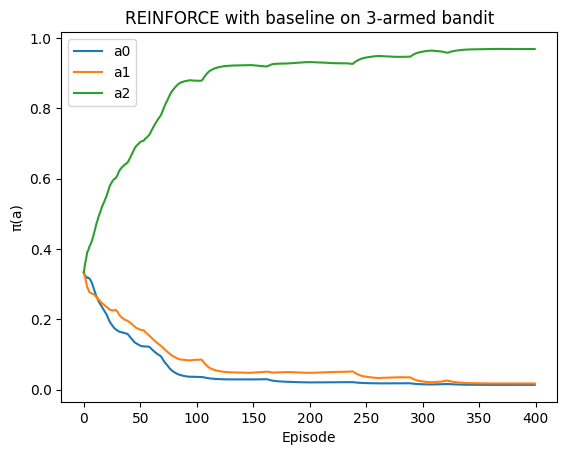

array([0.01361458, 0.01762864, 0.96875674], dtype=float32)

In [12]:
# Tiny stateless 3-armed bandit as an episodic "environment"
probs_true = torch.tensor([0.2, 0.5, 0.8])  # success probabilities per arm
def run_bandit_episode(a):
    reward = 1.0 if random.random()<probs_true[a].item() else -1.0
    return reward

# Softmax policy with preferences theta in R^3
theta = torch.zeros(3, requires_grad=True)
opt = optim.Adam([theta], lr=0.05)
baseline = 0.0

hist=[]
for ep in range(400):
    # sample action from current policy
    pi = torch.softmax(theta, dim=0)
    a  = int(torch.multinomial(pi, 1))
    r  = run_bandit_episode(a)
    G  = r  # one-step return
    # REINFORCE update with baseline (moving average)
    loss = - (G - baseline) * torch.log(pi[a])
    opt.zero_grad(); loss.backward(); opt.step()
    baseline = 0.9*baseline + 0.1*G
    hist.append((pi.detach().numpy(), r))

pis = np.stack([h[0] for h in hist])
plt.figure(); plt.plot(pis); plt.legend([f"a{i}" for i in range(3)]); plt.title("REINFORCE with baseline on 3-armed bandit"); plt.xlabel("Episode"); plt.ylabel("π(a)"); plt.show()
pis[-1]

## One-step actor–critic with TD error (advantage)

Use a critic $\hat{v}(s;w)$ to form a 1-step **advantage**
$$
\delta_t = R_{t+1} + \gamma \hat{v}(S_{t+1};w) - \hat{v}(S_t;w),
$$
and update both actor and critic:
$$
w \leftarrow w + \alpha_w\,\delta_t \nabla \hat{v}(S_t;w),\qquad
\theta \leftarrow \theta + \alpha_\theta\,\delta_t \nabla \log \pi_\theta(A_t|S_t).
$$
Below: tiny actor–critic on the vector-state environment.


/var/folders/mg/f7gk10vj1_153rz1zkvd13_00000gn/T/ipykernel_4849/2692726773.py:41: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  target = (r + gamma * float(v_ns))  # scalar float target


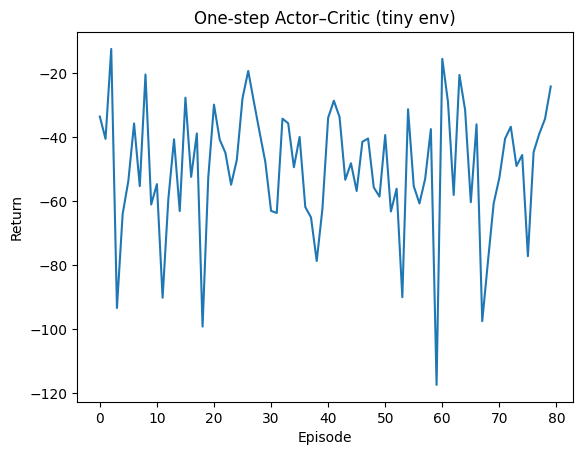

-44.3672975897789

In [13]:
class VNet(nn.Module):
    def __init__(self, din=4, hid=64):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(din, hid), nn.ReLU(), nn.Linear(hid, 1))

    def forward(self, x): return self.net(x).squeeze(-1)


class PiNet(nn.Module):
    def __init__(self, din=4, nact=2, hid=64):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(din, hid), nn.ReLU(), nn.Linear(hid, nact))

    def forward(self, x): return F.log_softmax(self.net(x), dim=-1)  # return log-probs


env = TinyEnv(T=25)
v = VNet();
pi = PiNet()
opt_v = optim.Adam(v.parameters(), lr=1e-3)
opt_pi = optim.Adam(pi.parameters(), lr=1e-3)

gamma = 0.98
rets = []
for ep in range(80):
    s = env.reset();
    done = False;
    G = 0.0
    while not done:
        s_t = torch.tensor(s[None, :], dtype=torch.float32)
        logp = pi(s_t)  # [1,2]
        a = int(torch.distributions.Categorical(logits=logp).sample().item())
        ns, r, done, _ = env.step(a)
        v_s = v(s_t)  # keep graph for critic
        if not done:
            ns_t = torch.tensor(ns[None, :], dtype=torch.float32)
            v_ns = v(ns_t)
        else:
            v_ns = torch.tensor(0.0)
        # compute TD target and delta as tensors to keep grad for critic only
        target = (r + gamma * float(v_ns))  # scalar float target
        delta = target - float(v_s)  # scalar float advantage for actor
        # critic
        loss_v = (v_s - target) ** 2
        opt_v.zero_grad();
        loss_v.backward();
        opt_v.step()
        # actor (detach advantage to avoid backprop through critic)
        loss_pi = - torch.tensor(delta) * logp[0, a]
        opt_pi.zero_grad();
        loss_pi.backward();
        opt_pi.step()
        s = ns;
        G += r
    rets.append(G)

plt.figure();
plt.plot(rets);
plt.xlabel("Episode");
plt.ylabel("Return");
plt.title("One-step Actor–Critic (tiny env)");
plt.show()
float(np.mean(rets[-10:]))


## PPO (clipped) on a super-tiny continuous control toy

We fit a 1D Gaussian policy mean $\mu_\theta$ (fixed $\sigma$) to output an action $a$, and the environment
returns reward $r=-(a-a^\*)^2$ with a slowly drifting target $a^\*$. We optimize the **clipped objective**:
$$
L^{\text{clip}}(\theta) = \mathbb{E}\big[\min\big(r_t(\theta)\,\hat{A}_t,\ \mathrm{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\,\hat{A}_t\big)\big],
$$
where $r_t(\theta)=\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{\text{old}}}(a_t|s_t)}$. This is purely illustrative to show the mechanics.


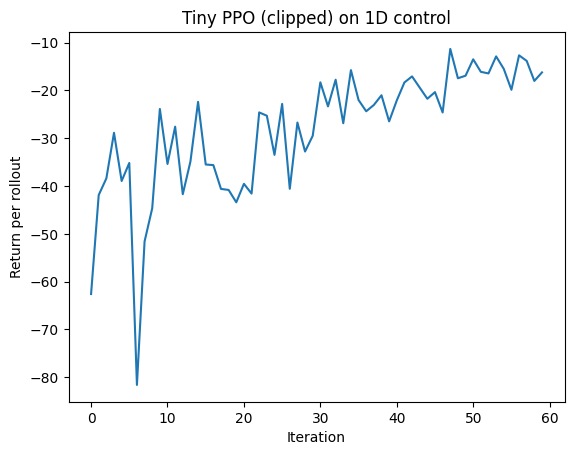

-15.519940509994546

In [14]:
class TinyContEnv:
    def __init__(self):
        self.t=0
    def reset(self):
        self.t=0; return np.array([0.0], dtype=np.float32)  # dummy state
    def step(self, a):
        self.t += 1
        a_star = math.sin(self.t/20.0)  # slowly varying target
        r = - (a - a_star)**2
        done = self.t>=30
        return np.array([0.0], dtype=np.float32), float(r), done, {}

class GaussianPolicy(nn.Module):
    def __init__(self, din=1):
        super().__init__()
        self.mean = nn.Linear(din,1)
        self.logstd = nn.Parameter(torch.tensor(0.0))
    def forward(self, x):
        mu = self.mean(x)
        std = torch.exp(self.logstd)
        return mu, std
    def log_prob(self, x, a):
        mu, std = self(x)
        return -0.5*((a-mu)/std).pow(2) - torch.log(std) - 0.5*math.log(2*math.pi)

def collect_traj(env, pi, T=30):
    s = env.reset()
    S,A,R,LP = [],[],[],[]
    for _ in range(T):
        s_t = torch.tensor(s[None,:], dtype=torch.float32)
        mu, std = pi(s_t)
        a = (mu + std*torch.randn_like(mu)).item()
        lp = pi.log_prob(s_t, torch.tensor([[a]], dtype=torch.float32)).item()
        ns, r, done, _ = env.step(a)
        S.append(s); A.append(a); R.append(r); LP.append(lp)
        s = ns
        if done: break
    # simple GAE(0) ~ discounted returns as advantage baseline 0
    G = 0.0; gamma=0.95; returns=[]
    for r in reversed(R):
        G = r + gamma*G; returns.append(G)
    returns = list(reversed(returns))
    # normalize advantages
    adv = np.array(returns); adv = (adv-adv.mean())/(adv.std()+1e-6)
    return np.array(S), np.array(A), np.array(R), np.array(LP), adv

env = TinyContEnv()
pi = GaussianPolicy(din=1)
opt = optim.Adam(pi.parameters(), lr=3e-3)
eps = 0.2

hist=[]
for it in range(60):
    S,A,R,LP_old,ADV = collect_traj(env, pi, T=30)
    S_t = torch.tensor(S, dtype=torch.float32)
    A_t = torch.tensor(A[:,None], dtype=torch.float32)
    ADV_t = torch.tensor(ADV, dtype=torch.float32)
    LP_old_t = torch.tensor(LP_old, dtype=torch.float32)
    for _ in range(5):  # a few epochs over the same batch
        lp = pi.log_prob(S_t, A_t).squeeze(-1)
        ratio = torch.exp(lp - LP_old_t)
        unclipped = ratio * ADV_t
        clipped   = torch.clamp(ratio, 1-eps, 1+eps) * ADV_t
        loss = - torch.min(unclipped, clipped).mean()
        opt.zero_grad(); loss.backward(); opt.step()
    hist.append(np.sum(R))

plt.figure(); plt.plot(hist); plt.xlabel("Iteration"); plt.ylabel("Return per rollout"); plt.title("Tiny PPO (clipped) on 1D control"); plt.show()
float(np.mean(hist[-10:]))

## Summary

- **Deep value methods:** target networks, replay, **Double DQN**, **Dueling**, and **Prioritized** replay.
- **Policy gradients:** softmax REINFORCE, baselines (advantages), and **actor–critic** with TD error.
- **PPO:** a stabilized policy-gradient method using a clipped surrogate objective.

Next steps:
- Combine **dueling + double + prioritized** for a stronger DQN.
- Replace toy envs with Gymnasium tasks (e.g., CartPole, MountainCar).
- Try $n$-step returns and GAE($\lambda$) for the actor–critic/PPO examples.


## Algorithms and frameworks at a glance

- **Value-based (offline-friendly):** Deep Q-Learning and its extensions (**Rainbow**: Double Q, Dueling, Prioritized Replay, Multi-step, Noisy Nets, Distributional).
- **On-policy actor–critic:** **PPO** with advantage estimation; practical default for many continuous/discrete tasks.
- **Off-policy actor–critic:** **SAC** for continuous control (entropy-regularized, stochastic policy).
- **Frameworks:** *Gymnasium* for environments, *Stable-Baselines3* for reliable baselines, *Ray RLlib* for distributed training.


## Deep Q-Learning: target networks (hard vs. soft)

To stabilize bootstrapping, use a separate **target** network with weights $w^-$.

- **Hard update** every $K$ steps: $w^- \leftarrow w$.
- **Soft update** (Polyak averaging): $w^- \leftarrow \tau w + (1-\tau)w^-$ with $\tau \in (0,1]$.

Targets:
$$
y_j = R_j + \gamma \max_{a'} \hat{Q}(S_{j+1}, a'; w^-).
$$


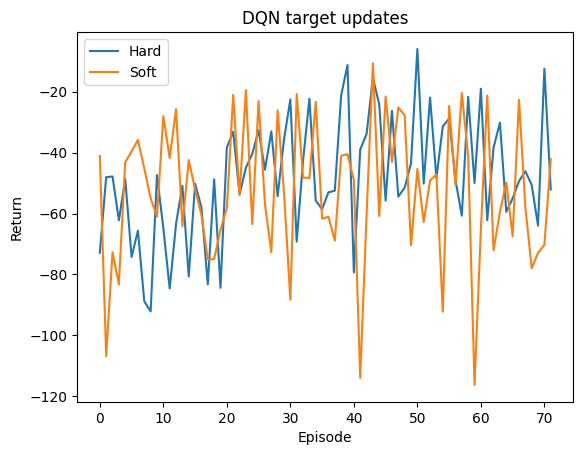

(-45.74661420881748, -59.2452745616436)

In [16]:
# Tiny vector-state env and DQN with hard/soft target updates
class TinyEnv:
    def __init__(self, T=25):
        self.T=T
    def reset(self):
        self.t=0
        self.s = np.random.randn(4).astype(np.float32)
        return self.s.copy()
    def step(self, a):
        self.t+=1
        self.s = (self.s + (0.05 if a==0 else -0.05)).astype(np.float32)
        r = -float(np.linalg.norm(self.s))
        done = self.t>=self.T or np.linalg.norm(self.s)<0.1
        return self.s.copy(), r, done, {}

class QNet(nn.Module):
    def __init__(self, din=4, nact=2, hid=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(din,hid), nn.ReLU(),
            nn.Linear(hid,hid), nn.ReLU(),
            nn.Linear(hid,nact),
        )
    def forward(self,x): return self.net(x)

def soft_update(target, source, tau=0.02):
    with torch.no_grad():
        for tp, sp in zip(target.parameters(), source.parameters()):
            tp.copy_(tau*sp + (1-tau)*tp)

def select_action(qnet, s, eps=0.1):
    if random.random()<eps: return random.randrange(2)
    with torch.no_grad():
        q = qnet(torch.tensor(s[None,:], dtype=torch.float32))
        return int(q.argmax(dim=1).item())

def train_dqn(update="hard", steps=1200):
    env = TinyEnv()
    q, qt = QNet(), QNet(); qt.load_state_dict(q.state_dict())
    opt = optim.Adam(q.parameters(), lr=1e-3)
    buf = collections.deque(maxlen=4000)
    ret_hist=[]; s=env.reset(); G=0.0; done=False
    for t in range(steps):
        a = select_action(q, s, eps=0.2)
        ns, r, done, _ = env.step(a)
        buf.append((s,a,r,ns,done)); s=ns; G+=r
        if done:
            ret_hist.append(G); s=env.reset(); G=0.0; done=False
        if len(buf)>=512:
            batch = random.sample(buf, 64)
            S,A,R,NS,D = zip(*batch)
            S = torch.tensor(np.array(S), dtype=torch.float32)
            A = torch.tensor(A).view(-1,1)
            R = torch.tensor(R, dtype=torch.float32)
            NS= torch.tensor(np.array(NS), dtype=torch.float32)
            D = torch.tensor(D, dtype=torch.float32)
            with torch.no_grad():
                q_next = qt(NS).max(dim=1).values
                tgt = R + 0.98*(1.0-D)*q_next
            pred = q(S).gather(1, A).squeeze(1)
            loss = F.mse_loss(pred, tgt)
            opt.zero_grad(); loss.backward(); opt.step()
        if update=="hard" and t%100==0:
            qt.load_state_dict(q.state_dict())
        if update=="soft" and t%5==0:
            soft_update(qt, q, tau=0.02)
    return ret_hist

r_hard = train_dqn(update="hard", steps=1800)
r_soft = train_dqn(update="soft", steps=1800)

plt.figure(); plt.plot(r_hard, label="Hard"); plt.plot(r_soft, label="Soft"); 
plt.xlabel("Episode"); plt.ylabel("Return"); plt.title("DQN target updates"); plt.legend(); plt.show()
float(np.mean(r_hard[-10:])), float(np.mean(r_soft[-10:]))

## Double DQN to curb overestimation

Use the **online** network to select the action and the **target** network to evaluate it:
$$
y = R + \gamma\, Q\!\left(S', \arg\max_a Q(S',a; w)\,;\,w^-\right).
$$


In [17]:
def ddqn_targets(q, qt, NS, R, D, gamma=0.98):
    with torch.no_grad():
        a_sel = q(NS).argmax(dim=1, keepdim=True)                  # action selection
        q_eval= qt(NS).gather(1, a_sel).squeeze(1)                 # evaluation
        return R + gamma*(1.0-D)*q_eval

# Quick check against plain DQN targets
S = torch.randn(8,4); NS = torch.randn(8,4)
A = torch.randint(0,2,(8,1))
R = torch.randn(8); D = torch.randint(0,2,(8,), dtype=torch.float32)
q, qt = QNet(), QNet()
t_ddqn = ddqn_targets(q, qt, NS, R, D)
t_dqn  = (R + 0.98*(1.0-D)*qt(NS).max(dim=1).values)
t_ddqn[:3], t_dqn[:3]

(tensor([1.3430, 0.6938, 1.1393]),
 tensor([1.3430, 0.6938, 1.1393], grad_fn=<SliceBackward0>))

## Rainbow components (quick sketches)

- **Multi-step targets ($n$-step):**
$$
y^{(n)} = \sum_{k=0}^{n-1} \gamma^k r_{t+k+1} + \gamma^n \max_{a'} Q(s_{t+n}, a'; w^-).
$$

- **Noisy Nets:** replace linear layers with parameterized noise to drive exploration.
- **Distributional DQN:** predict a value **distribution** over atoms $z_i$ with probabilities $p_i$.
- **Prioritized Replay:** sample proportionally to $|\delta|^\alpha$ with IS weights.
- **Dueling:** $Q(s,a)=V(s)+A(s,a)-\frac{1}{|A|}\sum_b A(s,b)$.


In [18]:
# Minimal noisy linear layer and prioritized replay (proportional)
class NoisyLinear(nn.Module):
    def __init__(self, in_f, out_f, sigma0=0.5):
        super().__init__()
        self.mu = nn.Parameter(torch.empty(out_f, in_f).uniform_(-1/math.sqrt(in_f), 1/math.sqrt(in_f)))
        self.sigma = nn.Parameter(torch.full((out_f, in_f), sigma0/math.sqrt(in_f)))
        self.bias = nn.Parameter(torch.zeros(out_f))
    def forward(self, x):
        eps = torch.randn_like(self.mu)
        w = self.mu + self.sigma*eps
        return x @ w.t() + self.bias

class PrioritizedReplay:
    def __init__(self, cap=10000, alpha=0.6, beta=0.4, eps=1e-3):
        self.cap=cap; self.alpha=alpha; self.beta=beta; self.eps=eps
        self.buf=[]; self.prior=[]; self.pos=0
    def push(self, tr, prio=1.0):
        if len(self.buf)<self.cap:
            self.buf.append(tr); self.prior.append(prio)
        else:
            self.buf[self.pos]=tr; self.prior[self.pos]=prio; self.pos=(self.pos+1)%self.cap
    def sample(self, batch):
        P = np.array(self.prior, dtype=np.float64)**self.alpha
        P = P / P.sum()
        idx = np.random.choice(len(self.buf), batch, p=P)
        s,a,r,ns,d = zip(*[self.buf[i] for i in idx])
        w = (len(self.buf)*P[idx])**(-self.beta); w = w/w.max()
        return (torch.tensor(np.array(s), dtype=torch.float32),
                torch.tensor(a), torch.tensor(r, dtype=torch.float32),
                torch.tensor(np.array(ns), dtype=torch.float32),
                torch.tensor(d, dtype=torch.float32),
                torch.tensor(idx), torch.tensor(w, dtype=torch.float32))

# quick sanity check
noisy = NoisyLinear(5,3); x = torch.randn(2,5); (noisy(x).shape,)


(torch.Size([2, 3]),)

## PPO fundamentals: importance ratios, clipped objective, and GAE

For samples from the **old** policy $\pi_{\theta_\text{old}}$, define the ratio
$$
r_t(\theta)=\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_\text{old}}(a_t|s_t)}.
$$
PPO maximizes
$$
L^{\text{clip}}(\theta)=\mathbb{E}\big[\min\big(r_t(\theta)\,\hat{A}_t,\ \mathrm{clip}(r_t(\theta),1-\epsilon,1+\epsilon)\,\hat{A}_t\big)\big].
$$

Generalized Advantage Estimation (GAE) computes smoother advantages:
$$
\hat{A}_t = \sum_{l=0}^{\infty} (\gamma\lambda)^l\,\delta_{t+l},\quad
\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t).
$$


In [19]:
def compute_gae(rewards, values, dones, gamma=0.99, lam=0.95):
    # rewards, values, dones are 1D numpy arrays for a single rollout (T steps)
    T = len(rewards)
    adv = np.zeros(T, dtype=np.float32)
    lastgaelam = 0.0
    for t in reversed(range(T)):
        nonterminal = 1.0 - dones[t]
        delta = rewards[t] + gamma * values[t+1] * nonterminal - values[t]
        lastgaelam = delta + gamma * lam * nonterminal * lastgaelam
        adv[t] = lastgaelam
    returns = adv + values[:-1]
    return adv, returns

# quick check
rewards = np.array([1,0,0,1], dtype=np.float32)
values  = np.array([0.5,0.4,0.3,0.2,0.0], dtype=np.float32)  # T+1 values (bootstrap)
dones   = np.array([0,0,0,1], dtype=np.float32)
compute_gae(rewards, values, dones)

(array([1.3744335, 0.5087012, 0.6504   , 0.8      ], dtype=float32),
 array([1.8744335, 0.9087012, 0.9504   , 1.       ], dtype=float32))

## Tiny PPO with vectorized rollouts (toy env)

We implement a minimal PPO loop with:
- vectorized copies of a tiny environment,
- GAE advantages,
- clipped objective,
- entropy bonus and value loss (with a coefficient).

This is didactic (not tuned for performance).


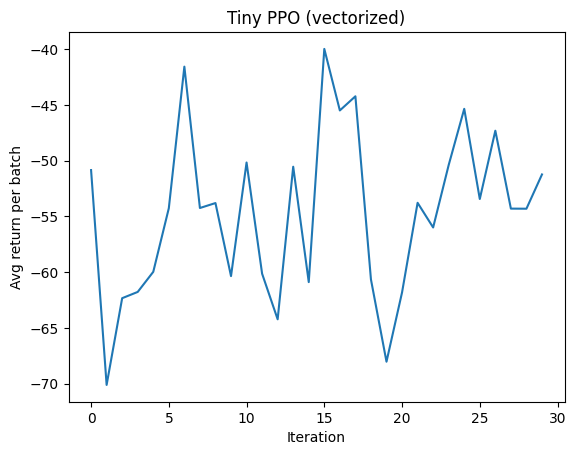

[-53.44645309448242,
 -47.31988525390625,
 -54.30743408203125,
 -54.31646728515625,
 -51.24388122558594]

In [20]:
class VecTinyEnv:
    def __init__(self, n=8, T=32):
        self.n=n; self.T=T
        self.envs=[TinyEnv(T=T) for _ in range(n)]
    def reset(self):
        return np.stack([e.reset() for e in self.envs])
    def step(self, actions):
        S,R,D,NS = [],[],[],[]
        for e,a in zip(self.envs, actions):
            ns,r,d,_ = e.step(int(a))
            S.append(ns); R.append(r); D.append(d); NS.append(ns if not d else e.reset())
        return np.stack(NS), np.array(R, np.float32), np.array(D, np.float32)

class ActorCritic(nn.Module):
    def __init__(self, din=4, nact=2, hid=64):
        super().__init__()
        self.pi = nn.Sequential(nn.Linear(din,hid), nn.Tanh(), nn.Linear(hid,hid), nn.Tanh(), nn.Linear(hid,nact))
        self.v  = nn.Sequential(nn.Linear(din,hid), nn.Tanh(), nn.Linear(hid,1))
    def forward(self,x):
        logits = self.pi(x); v = self.v(x).squeeze(-1)
        return logits, v

def ppo_train(iters=40, n_env=8, T=32, epochs=4, mbsize=128, clip=0.2, vf_coef=0.5, ent_coef=0.01, lr=3e-3):
    device="cpu"
    net = ActorCritic().to(device)
    opt = optim.Adam(net.parameters(), lr=lr)
    env = VecTinyEnv(n=n_env, T=T)
    obs = env.reset()
    logs=[]
    for it in range(iters):
        S,A,R,V,D,LP = [],[],[],[],[],[]
        for t in range(T):
            x = torch.tensor(obs, dtype=torch.float32, device=device)
            logits, v = net(x)
            pi = torch.distributions.Categorical(logits=logits)
            a = pi.sample()
            lp = pi.log_prob(a)
            obs_next, r, d = env.step(a.cpu().numpy())
            S.append(x.cpu().numpy()); A.append(a.cpu().numpy()); R.append(r); V.append(v.detach().cpu().numpy()); D.append(d); LP.append(lp.detach().cpu().numpy())
            obs = obs_next
        # bootstrap value
        with torch.no_grad():
            v_boot = net(torch.tensor(obs, dtype=torch.float32, device=device))[1].cpu().numpy()
        S = np.stack(S); A=np.stack(A); R=np.stack(R); V=np.stack(V); D=np.stack(D); LP=np.stack(LP)
        # compute GAE per env and flatten
        adv_all=[]; ret_all=[]
        for i in range(n_env):
            adv, ret = compute_gae(R[:,i], np.concatenate([V[:,i],[v_boot[i]]]), D[:,i], gamma=0.99, lam=0.95)
            adv_all.append(adv); ret_all.append(ret)
        ADV = np.stack(adv_all).T; RET=np.stack(ret_all).T
        ADV = (ADV - ADV.mean())/(ADV.std()+1e-8)
        # flatten rollout
        B = n_env*T
        Sb = torch.tensor(S.reshape(B, -1), dtype=torch.float32, device=device)
        Ab = torch.tensor(A.reshape(B), dtype=torch.long, device=device)
        LPb= torch.tensor(LP.reshape(B), dtype=torch.float32, device=device)
        ADVb=torch.tensor(ADV.reshape(B), dtype=torch.float32, device=device)
        RETb=torch.tensor(RET.reshape(B), dtype=torch.float32, device=device)
        # PPO updates
        idx = np.arange(B)
        for ep in range(epochs):
            np.random.shuffle(idx)
            for j in range(0,B,mbsize):
                ids = idx[j:j+mbsize]
                logits, v = net(Sb[ids])
                pi = torch.distributions.Categorical(logits=logits)
                lp = pi.log_prob(Ab[ids])
                ratio = torch.exp(lp - LPb[ids])
                unclipped = ratio * ADVb[ids]
                clipped   = torch.clamp(ratio, 1-clip, 1+clip) * ADVb[ids]
                loss_pi = -torch.min(unclipped, clipped).mean()
                loss_v  = F.mse_loss(v, RETb[ids])
                ent = pi.entropy().mean()
                loss = loss_pi + vf_coef*loss_v - ent_coef*ent
                opt.zero_grad(); loss.backward(); opt.step()
        # logging: approximate return
        logs.append(float(np.mean(R.sum(axis=0))))
    plt.figure(); plt.plot(logs); plt.xlabel("Iteration"); plt.ylabel("Avg return per batch"); plt.title("Tiny PPO (vectorized)"); plt.show()
    return logs[-5:]

ppo_train(iters=30)

## Practical PPO choices (what often matters)

- **Networks:** separate actor/critic; 2 hidden layers; $\\tanh$ often works well; small final-layer init on actor.
- **Sampling:** vectorized envs; tune rollout length $T$; multiple epochs over data; shuffle minibatches.
- **Advantage:** GAE($\lambda$) with $\gamma\in[0.97,0.999]$, $\lambda\in[0.9,0.97]$.
- **Losses:** clipped surrogate; add entropy bonus; value loss with a coefficient; optional KL early-stop.
- **Optimization:** Adam; learning rate $\approx 3\cdot 10^{-4}$ as a starting point; normalize advantages.


## Multi-agent sketch and message passing

For grid **crossing** tasks, agents can share messages. Without extra libraries, we can implement a **simple message-passing step** by averaging neighbor embeddings with an adjacency matrix $A$:
$$
H^{(l+1)} = \sigma\!\left( A\,H^{(l)} W^{(l)} \right).
$$
Below is a tiny message-passing example (not a full environment).

In [21]:
# Tiny message passing over a fixed 4-node graph
class TinyMP(nn.Module):
    def __init__(self, din=8, dh=16):
        super().__init__()
        self.lin = nn.Linear(din, dh, bias=False)
    def forward(self, H, A):
        return torch.tanh(A @ self.lin(H))

# 4 nodes, random features
H = torch.randn(4, 8)
# ring adjacency (normalized)
A = torch.tensor([[0,1,0,1],
                  [1,0,1,0],
                  [0,1,0,1],
                  [1,0,1,0]], dtype=torch.float32)
A = A / A.sum(dim=1, keepdim=True)
net = TinyMP(8, 16)
H2 = net(H, A)
H.shape, H2.shape

(torch.Size([4, 8]), torch.Size([4, 16]))

## Summary

- **DQN → Rainbow:** target networks (hard/soft), Double Q, Noisy layers, Prioritized Replay, $n$-step, and distributional value heads.
- **PPO:** clipped objective, GAE, entropy bonus, vectorized rollouts, and implementation details that strongly affect results.
- **Multi-agent hints:** simple message passing as a stand-in for GNN communication.

Next steps:
- Combine **Double + Dueling + Prioritized** in the DQN loop.
- Add KL early-stopping to PPO; sweep rollout lengths and minibatch sizes.
- Swap toy envs for Gymnasium tasks; try SAC for continuous control.
